In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
import logging
import os
import re

import dask.array as da
import dask.dataframe as dd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import seaborn as sns
import xarray as xr
from ipywidgets import IntSlider, interact
from scipy import stats

<IPython.core.display.Javascript object>

In [3]:
logging.getLogger().setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [4]:
# util functions
# normally I would have a utils files but as this is a bit more exploratory space I 
# haven't moved them to a separate file yet. 
def extract_numeric_part(file_path: str) -> int:
    """
    This function extracts the numeric part of a file,
    i.e "1234.tif".

    Parameters
    ----------
    file_path:str
        File path we want to extract numbers from.

    Returns
    -------
    int

    """
    number = re.search(r"\d+", os.path.basename(file_path))
    return int(number.group()) if number else None

def plot_ndvi(index:int):
    """
    Function to plot NDVI data across observations.
    
    Parameters
    ----------
    index: int
        Slice we want to plot.
    
    Return
    ------
    
    """
    ndvi_data = ndvi[index].compute()  # Compute the specific slice for visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi_data, cmap="RdYlGn")
    plt.title(f"NDVI - Observation {index}")
    plt.colorbar()
    plt.axis("off")
    plt.show()


<IPython.core.display.Javascript object>

In [5]:
# we are going to work with surface reflectance data instead of TOA
# so that we can deal with something that processed to account for environmental effects
LANDSAT_FILE_PATH = "/mnt/landsat_data/Landsat_Surface_Reflectance/"

<IPython.core.display.Javascript object>

In [6]:
surface_reflectance_files = glob.glob(os.path.join(LANDSAT_FILE_PATH, "*.tif"))

<IPython.core.display.Javascript object>

In [7]:
# these tif files are a mess, they are not in order and there are duplicates as suggested
# by artifacts like (1)... lets clean this up and sort them properly.

# remove (1) or other cases with parenthesis as this indicates a duplicate
cleaned_surface_reflectance_files = [
    re.sub(r"\(\d+\)", "", file) for file in surface_reflectance_files
]

# Sort the remaining files based on the numeric part
sorted_surface_reflectance_files = sorted(
    list(set(cleaned_surface_reflectance_files)), key=extract_numeric_part
)

<IPython.core.display.Javascript object>

In [8]:
# lets store all of our tif files in an array
data_arrays = [
    rxr.open_rasterio(file_path, masked=True).squeeze()
    for file_path in sorted_surface_reflectance_files
]

<IPython.core.display.Javascript object>

In [9]:
# there are issues where the arrays are not the same shape, for simplicity and to enable
# exploration I am just going to chuck the arrays that don't have the same shape.
# obviously I would typically explore this further but as this is a sandbox I'm not going to jump
# into why this is happening (at least not yet...)
filtered_data_arrays = [
    da for da in data_arrays if da.shape[2] == 32 and da.shape[1] == 32
]

<IPython.core.display.Javascript object>

In [10]:
# Convert list of xarray DataArrays to a dask array for parallel processing
dask_data = da.stack([da.data for da in filtered_data_arrays])

<IPython.core.display.Javascript object>

In [11]:
dask_data

dask.array<stack, shape=(13914, 11, 32, 32), dtype=float32, chunksize=(1, 11, 32, 32), chunktype=numpy.ndarray>

<IPython.core.display.Javascript object>

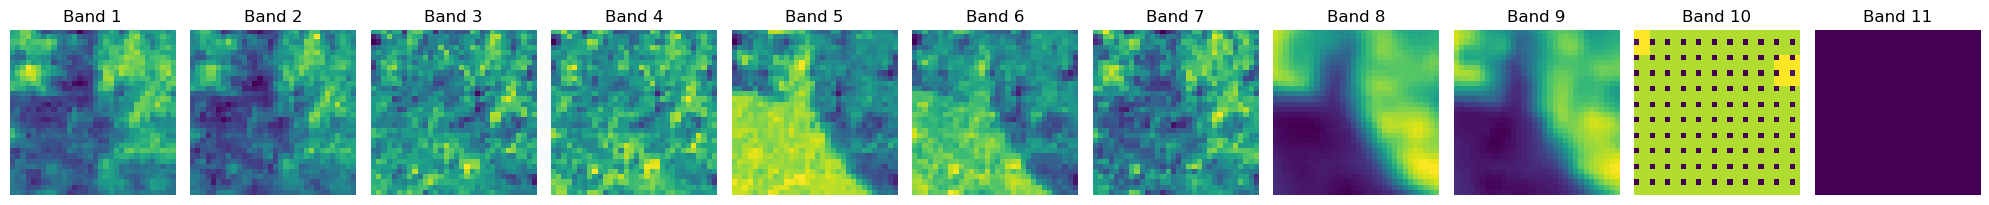

<IPython.core.display.Javascript object>

In [12]:
# lets visualize the bands !!!!
observation = dask_data[0].compute()

# Plot each band for a single observation
fig, axes = plt.subplots(1, 11, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(observation[i], cmap="viridis")
    ax.set_title(f"Band {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# guide to bands:
# B1 - Coastal/Aerosol
# B2 - Blue (water body mapping, differentiating between vegetation and soil)
# B3 - Green (vegetation health)
# B4 - Red (discriminating between vegetation and soil)
# B5 - Near Infrared (NIR) (biomass, water bodies)
# B6 - Shortwave Infrared 1 (moisture content of soil and vegetation)
# B7 - Shortwave Infrared 2 (snow/ice, burnt areas)
# B8 - panchromatic (higer res)
# B9 - Cirrus (cloud properties)
# B10 - Thermal Infrared 1 (surface temp)
# B11 - Thermal Infrared 2 (surface temp)

<IPython.core.display.Javascript object>

In [14]:
# Courtesy of the internet, I was able to determine which bands
# we need for NDVI calculation as well as how you calculate NDVI
# I went with NDVI because I've worked with this index before (it's been a minute though)
nir_band = dask_data[:, 4, :, :]  # NIR band
red_band = dask_data[:, 3, :, :]  # Red band

# NDVI calculation
ndvi = (nir_band - red_band) / (nir_band + red_band)

<IPython.core.display.Javascript object>

In [15]:
# Use interact to create the slider
interact(plot_ndvi, index=(0, dask_data.shape[0] - 1))

interactive(children=(IntSlider(value=6956, description='index', max=13913), Output()), _dom_classes=('widget-…

<function __main__.plot_ndvi(index: int)>

<IPython.core.display.Javascript object>